In [1]:
from jax.config import config
config.update("jax_enable_x64", True)

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

import pickle
import scipy.optimize
from hyperion.utils import cherenkov_ang_dist, ANG_DIST_INT
from tqdm.notebook import trange, tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

import sys
sys.path.append("../gnn_testbed")
from gnn_testbed.event_generation import (
    Detector,
    make_line,
)
from gnn_testbed.event_generation.photon_propagation import make_generate_photons_nn, source_to_model_input, PhotonSource
from gnn_testbed.event_generation import generate_cascade
from hyperion.models.photon_arrival_time.net import PhotonArivalTimePars
from hyperion.models.photon_arrival_time.pdf import make_exp_exp_exp, sample_exp_exp_exp

%matplotlib inline


from jax import numpy as jnp
from jax import value_and_grad, jit
import pandas as pd
from glob import glob

import awkward as ak
from torch.autograd.functional import hessian, jacobian

In [2]:
rng = np.random.RandomState(31338)
oms_per_line = 20
dist_z = 50
dark_noise_rate = 16 * 1E-6 # 1/ns

modules = make_line(0, 0, oms_per_line, dist_z, rng, dark_noise_rate, 0, efficiency=0.3)
modules += make_line(0, 100, oms_per_line, dist_z, rng, dark_noise_rate, 1, efficiency=0.3)
modules += make_line(100, 0, oms_per_line, dist_z, rng, dark_noise_rate, 2, efficiency=0.3)
det = Detector(modules)


lc_links = {}
for i in range(60):
  
    links = list(range(max(i-1, (i//20)*20), min(i+2, (i//20+1)*20)))
    links.remove(i)
    lc_links[i] = links

height = 1500
radius = 200


In [3]:
def sph_to_cart(theta, phi=0):
    """Transform spherical to cartesian coordinates."""
    x = torch.sin(theta) * torch.cos(phi)
    y = torch.sin(theta) * torch.sin(phi)
    z = torch.cos(theta)
    
    out = torch.empty(3, device=device, dtype=torch.float)
    out[0] = x
    out[1] = y
    out[2] = z
    
    return out

def sph_to_cart_np(theta, phi=0, r=1):
    """Transform spherical to cartesian coordinates."""
    x = np.sin(theta) * np.cos(phi)
    y = np.sin(theta) * np.sin(phi)
    z = np.cos(theta)

    return np.asarray([x, y, z])


In [591]:
def source_to_model_input_torch(module_coords, source_pos, source_dir, source_t0, c_vac, n_gr):
    """Convert photon sources an module coordinates into neural net input."""

    source_targ_vec = module_coords - source_pos
    dist = torch.linalg.norm(source_targ_vec, dim=-1)
    angles = torch.arccos(torch.einsum("ak, k -> a", source_targ_vec, source_dir) / dist)
    time_geo = dist / (c_vac / n_gr) + source_t0
    
    inp_pars = torch.stack([angles, torch.log10(dist)], axis=1)
    return inp_pars, time_geo


def expon_pdf(x, a):
    """Exponential PDF."""
    return 1 / a * torch.exp(-x[:, np.newaxis] / a)

def expon_int(x, a):
    """Exponential CDF"""
    return 1 - torch.exp(-x[:, np.newaxis] / a)


def weight_param(w1, w2):
    weights = torch.empty((w1.shape[0], 3), device=device)
    weights[:, 0] = torch.sin(w1) * torch.cos(w2)
    weights[:, 1] = torch.sin(w1) * torch.sin(w2)
    weights[:, 2] = torch.cos(w1)
    weights = weights**2
    return weights

def triple_exp(xs, parameters):
    
    scales = parameters[:, 0:3] * 100
    scales, indices = torch.sort(scales, dim=1)
    w1 = parameters[:, 3]
    w2 = parameters[:, 4]
    

    weights = weight_param(w1, w2)


    res = torch.log(
        weights[:, 0] * expon_pdf(xs, scales[:, 0])
        + weights[:, 1] * expon_pdf(xs, scales[:, 1])
        + weights[:, 2] * expon_pdf(xs, scales[:, 2])
    )

    return res

def triple_exp_integral(tmax, parameters):
    
    scales = parameters[:, 0:3] * 100
    scales, indices = torch.sort(scales, dim=1)
    w1 = parameters[:, 3]
    w2 = parameters[:, 4]
    weights = weight_param(w1, w2)
    

    res = (
        weights[:, 0] * expon_int(tmax, scales[:, 0]) + 
        weights[:, 1] * expon_int(tmax, scales[:, 1]) + 
        weights[:, 2] * expon_int(tmax, scales[:, 2])
    )
   
    return res
    

def uniform_triple_exp(xs, parameters):
    log_usf = parameters[:, -2]
    usf = 1 - 10 ** (-log_usf)
    
    unif = torch.log(usf * 1/2)
    texp = torch.log(1-usf) +triple_exp(xs+2, parameters[:, :-2]) # TODO: Check +2!
    
    out = torch.where(xs < 2, unif, texp)
   
    return out

def uniform_triple_exp_int(tmax, parameters):
    log_usf = parameters[:, -2]
    usf = 1 - 10 ** (-log_usf)
    
    unif_int = usf * tmax / 2
    texp_int = (1-usf) * triple_exp_integral(tmax, parameters[:, :-2]) # TODO: Check +2!
    
    out = torch.where(tmax < 2, unif_int, texp_int+usf)
   
    return out


module_positions = torch.tensor(det.module_coords, dtype=torch.float, device=device)
net = torch.load("data/arival_time_pars_net.dat")
net.to("cuda")


def eval_dist(times, amp_exp, pos, theta, phi, t0, module_ix, mod_eff=0.3):
    cdir = sph_to_cart(theta, phi)
    model_in, tgeo = source_to_model_input_torch(module_positions, pos, cdir, t0, 0.3, 1.35)
    pdf_params = net(model_in).reshape(module_positions.shape[0], 7)
    
    twindow = torch.tensor(1000, device=device, dtype=torch.float) # TODO: Improve

    nnoise = dark_noise_rate * twindow
    amp_meas = times.shape[0]
    
    log_nph = pdf_params[module_ix, -1]
    surv_ratio = 10 ** log_nph / 300e7 
    n_ph_exp = amp_exp * surv_ratio * mod_eff

    times = times-tgeo[module_ix]
    tres_lh = torch.empty(times.shape, device=device)
    
    noise_term = torch.full(times.shape, torch.log(nnoise), device=device)

    trespdf_eval = torch.logsumexp(
        torch.stack(
            (uniform_triple_exp(times, pdf_params[module_ix][np.newaxis, :])[:, 0] + torch.log(n_ph_exp),
             noise_term),
            dim=-1)
        , dim=-1)

    tres_lh = torch.where(times >= 0, trespdf_eval, noise_term)
    
   
    
    return tres_lh, n_ph_exp
    

def eval_likelihood(event, amp_exp, pos, theta, phi, t0, mod_eff=0.3):
   
    cdir = sph_to_cart(theta, phi)
    model_in, tgeo = source_to_model_input_torch(module_positions, pos, cdir, t0, 0.3, 1.35)
    pdf_params = net(model_in).reshape(module_positions.shape[0], 7)
    
    likelihood = 0
    for i, times in enumerate(event):
        if len(times) == 0:
            continue
        times = torch.tensor(times, device=device, dtype=torch.float, requires_grad=True)- tgeo[i]
        twindow = torch.tensor(1000, device=device, dtype=torch.float) # TODO: Improve
        nnoise = dark_noise_rate * twindow

        log_nph = pdf_params[i, -1]
        surv_ratio = 10 ** log_nph / 300e7 
        n_ph_exp = amp_exp * surv_ratio * mod_eff

        tres_lh = torch.empty(times.shape, device=device)

        noise_term = torch.full(times.shape, torch.log(nnoise), device=device)


        trespdf_eval = torch.logsumexp(
            torch.stack(
                (uniform_triple_exp(times, pdf_params[i][np.newaxis, :])[:, 0] + torch.log(n_ph_exp),
                 noise_term),
                dim=-1)
            , dim=-1)
        
        tres_lh = torch.where(times >= 0, trespdf_eval, noise_term)
        
        likelihood += tres_lh.sum() - n_ph_exp

    return likelihood
    
    
    

In [594]:
1E12 / ( 5.3 * 250 * 1e2) / 1E6

7.547169811320755

In [583]:
theta = np.radians(30)
theta2 = np.radians(20)
phi = np.radians(10)
cdir = sph_to_cart_np(theta, phi)
cdir2 = sph_to_cart_np(theta2, phi)
pos = np.asarray([30., 40, 0])
t0_gen = 20
amp_gen = 1E10


gen_ph = make_generate_photons_nn("../hyperion/data/arival_time_pars_net.dat")
phsrc = PhotonSource(pos, amp_gen, 0, cdir)
samples = gen_ph(det.module_coords, det.module_efficiencies, [phsrc])

theta_t = torch.tensor(theta, device=device, dtype=torch.float)
theta2_t = torch.tensor(theta2, device=device, dtype=torch.float)
cdir_t = torch.tensor(cdir, device=device, dtype=torch.float)
phi_t = torch.tensor(phi, device=device, dtype=torch.float)
pos_t = torch.tensor(pos, device=device, dtype=torch.float)
amp_gen_t = torch.tensor(amp_gen, device=device, dtype=torch.float)
t0_gen_t = torch.tensor(t0_gen, device=device, dtype=torch.float)
xs = np.linspace(0, 500, 500)

event, record = generate_cascade(det, pos, t0_gen, cdir, n_photons=1E8,  pprop_func=gen_ph)
event2, record2 = generate_cascade(det, pos, t0_gen, cdir2, n_photons=1E8,  pprop_func=gen_ph)

In [592]:
model_in, tgeo = source_to_model_input_torch(module_positions, pos_t, cdir_t, t0_gen_t, 0.3, 1.35)
pdf_params = net(model_in).reshape(module_positions.shape[0], 7)
uniform_triple_exp_int(torch.tensor([5000], device=device, dtype=torch.float), pdf_params)

tensor([[1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000]], device='cuda:0',
       grad_fn=<SWhereBackward>)

In [576]:
inp_params.shape

torch.Size([60, 2])

In [530]:
def dpsi(zen1, azi1, zen2, azi2):
    v1 = sph_to_cart(zen1, azi1)
    v2 = sph_to_cart(zen2, azi2)
    return np.arccos(np.dot(v1, v2))

In [543]:
def make_obj_func(event, llh):
    def func(pars):
        pars = torch.tensor(pars, dtype=torch.float, device=device, requires_grad=True)
        val = -llh(event, 10**pars[0], pars[1:4], pars[4], pars[5], pars[6])
        val.backward()
        grads = pars.grad
        return np.asarray(val.detach().cpu().numpy(), dtype=np.float64), np.asarray(grads.detach().cpu().numpy(), dtype=np.float64)
    return func


results = []
for i in range(100):
    event, record = generate_cascade(det, pos, t0_gen, cdir, n_photons=amp_gen, pprop_func=gen_ph, seed=i)

    minfunc = make_obj_func(event, eval_likelihood)

    if phi > np.pi:
        phi_seed = phi - 2*np.pi
    else:
        phi_seed = phi
    res = scipy.optimize.fmin_l_bfgs_b(
        minfunc,
        (np.log10(amp_gen), pos[0], pos[1], pos[2], theta, phi_seed, t0_gen),
        bounds=((-1, None), (None, None), (None, None), (None, None), (0, np.pi), (-np.pi, np.pi), (None,None))
    )
    results.append(res[0])
        

    

In [544]:
results_df = pd.DataFrame(results, columns=["log10(E)", "x", "y", "z", "theta", "phi", "t"])



In [545]:
results_df["phi"] = results_df["phi"]

In [546]:
results_df.describe()

,log10(E),x,y,z,theta,phi,t
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,9.991931,29.837519,40.119795,-0.199552,0.540959,0.152957,20.094443
std,0.012585,0.094098,0.069418,0.122405,0.013628,0.020839,0.057223
min,9.936906,29.710017,40.015234,-0.555390,0.483275,0.020532,20.010529
25%,9.986023,29.729241,40.077552,-0.326447,0.533287,0.140981,20.055598
50%,9.995061,29.884621,40.085342,-0.135711,0.535687,0.157868,20.064027
75%,9.998581,29.898301,40.201581,-0.116437,0.553462,0.166256,20.155272
max,10.024909,29.980395,40.221210,-0.021938,0.567275,0.174660,20.241541


In [547]:
scipy.stats.circstd(results_df["phi"])

0.020729045719075308

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='phi', ylabel='Density'>

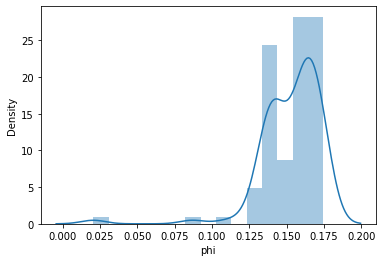

In [548]:
sns.distplot(results_df["phi"])

Text(0, 0.5, 'LLH')

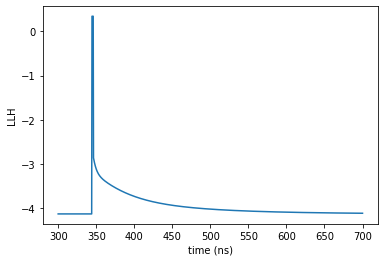

In [365]:
xs = np.linspace(300, 700, 1000)
xs_t = torch.tensor(xs, device=device, dtype=torch.float)
pdf_val, p = eval_dist(xs_t, amp_gen_t, pos_t, theta_t, phi_t, t0_gen, 30)

plt.plot(xs, pdf_val.detach().cpu())
plt.xlabel("time (ns)")
plt.ylabel("LLH")





In [595]:
def make_wrap(event):
    def wrap(logamp, theta, phi, pos_x, pos_y, pos_z, t0):
        pos = torch.stack([pos_x, pos_y, pos_z])
        res = eval_likelihood(event, 10**logamp, pos, theta, phi, t0)
        return res
    return wrap

def unpack_hessian(hess):
    hess_len = len(hess)
    out = np.empty((hess_len, hess_len))
    for i in range(len(hess)):
        for j in range(len(hess)):
            out[i, j] = hess[i][j].detach().cpu().numpy()
    return out
    

    
all_hessians = []
hessians = []
hessians_f = []

all_n_photons_gen = np.linspace(1E8, 1E12, 50)
for amp_gen in all_n_photons_gen:
    amp_gen_t = torch.tensor(amp_gen, device=device, dtype=torch.float)
    hessians_f = []
    for seed in range(200):
        event, record = generate_cascade(det, pos, t0_gen, cdir, n_photons=amp_gen, pprop_func=gen_ph)
        wrap = make_wrap(event)
        #hess = hessian(wrap, (torch.log10(amp_gen_t), theta_t, phi_t, pos_t[0], pos_t[1], pos_t[2], t0_gen_t), strict=True)
        jac = torch.stack(jacobian(wrap, (torch.log10(amp_gen_t), theta_t, phi_t, pos_t[0], pos_t[1], pos_t[2], t0_gen_t), strict=True))
        #hessians.append(unpack_hessian(hess))
        hessians_f.append((jac[np.newaxis, :] * jac[:, np.newaxis]).detach().cpu().numpy())
    all_hessians.append(hessians_f)

   
    


RuntimeError: CUDA out of memory. Tried to allocate 692.00 MiB (GPU 0; 3.82 GiB total capacity; 2.07 GiB already allocated; 656.12 MiB free; 2.09 GiB reserved in total by PyTorch)

In [550]:
hess_m = np.average(hessians, axis=0)
hess_mf = np.average(hessians_f, axis=0)

In [551]:
np.sqrt(np.diag(np.linalg.inv(hess_mf)))

array([0.01182786, 0.01607182, 0.02285083, 0.19836146, 0.14107321,
       0.33902225, 1.0296952 ], dtype=float32)

In [552]:
np.degrees(np.sqrt(np.linalg.inv(hess_mf)[1, 1]))

0.9208471

In [553]:
np.degrees(np.sqrt(np.linalg.inv(hess_mf)[2, 2]))

1.3092561

In [449]:
np.degrees(np.sqrt(np.linalg.inv(-hess_m)[2, 2]))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in sqrt
  """Entry point for launching an IPython kernel.


nan

In [339]:

model_in = source_to_model_input(det.module_coords, [phsrc])

xs = np.linspace(0, 100, 1000)
xs_t = torch.tensor(xs, device=device, dtype=torch.float)

plt.plot(xs, torch.exp(uniform_triple_exp(xs_t, pdf_params)[:, 30]).detach().cpu(), color="r")

#times = 
#sns.histplot(times, bins = np.linspace(0, 100, 100), stat="density")
#plt.semilogy()


TypeError: source_to_model_input() missing 2 required positional arguments: 'c_vac' and 'n_gr'

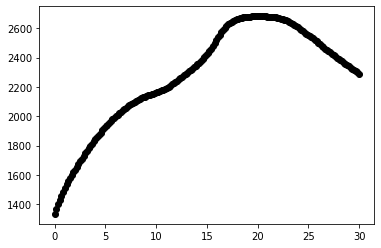

In [58]:
thetas = torch.linspace(np.radians(0), np.radians(30), 180)
for theta in thetas:
    plt.plot(np.degrees(theta.cpu().detach()), eval_dist(event2, 0.3*1E9, pos, theta, phi).cpu().detach(), "ok")


In [32]:
def wrap(theta, phi):        
    return eval_dist(event, 1E6, pos, theta, phi)

theta = torch.tensor(20., device=device)#
phi = torch.tensor(0., device=device)
hess = hessian(wrap, (theta, phi), strict=True)

In [33]:
hess

((tensor(-3.4984, device='cuda:0'), tensor(1.6891, device='cuda:0')),
 (tensor(1.6891, device='cuda:0'), tensor(2.5304, device='cuda:0')))

In [24]:

hessian(lambda theta, phi: net(source_to_model_input(module_positions, pos, sph_to_cart(theta, phi))).reshape(module_positions.shape[0], 7).sum(), (theta, phi))

((tensor(0., device='cuda:0'), tensor(0., device='cuda:0')),
 (tensor(0., device='cuda:0'), tensor(0., device='cuda:0')))

In [228]:
xs = torch.linspace(0, 200, 1000, device=device)
plt.plot(xs.detach().cpu(), uniform_triple_exp(xs, pdf_params[10, :-1]).detach().cpu())
plt.plot(xs.detach().cpu(), uniform_triple_exp(xs, pdf_params2[10, :-1]).detach().cpu())
#plt.semilogy()

IndexError: too many indices for tensor of dimension 1

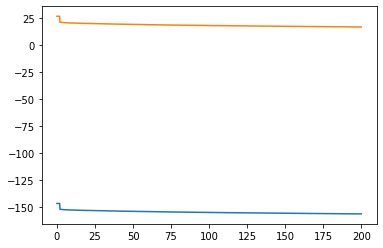

In [200]:
xs = torch.linspace(0, 200, 1000, device=device)
plt.plot(xs.detach().cpu(), poisson_utr_exp(1E5, xs, *pdf_params[10, ]).detach().cpu())
plt.plot(xs.detach().cpu(), poisson_utr_exp(1E5, xs, *pdf_params2[10, ]).detach().cpu())
#plt.semilogy()

In [139]:
torch.autograd.functional.hessian

tensor(0.0153, device='cuda:0', grad_fn=<RsubBackward1>)

In [126]:
pdf_params2[0]

tensor([ 0.1407,  0.4384,  0.7594,  0.7884,  0.6862,  0.0066, -6.5473],
       device='cuda:0', grad_fn=<SelectBackward>)

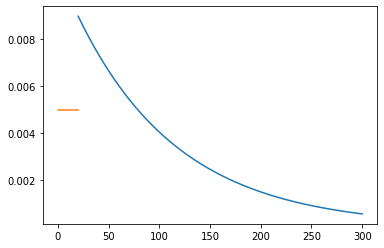

In [179]:
xs = np.linspace(0, 300, 1000)
plt.plot(xs[xs > 20], 0.9 * 1/100 * np.exp((-(xs[xs > 20]-20) / 100)))
plt.plot(xs[xs < 20], 0.1 * 1/20*np.ones((xs < 20).sum()))

In [180]:
def func(xs):
    xs = np.atleast_1d(xs)
    out = np.empty_like(xs)
    out[xs > 20] = 0.9 * 1/100 * np.exp((-(xs[xs > 20]-20)) / 100)
    out[xs <= 20] = 0.1 * 1/20*np.ones((xs <= 20).sum())
    return out

In [181]:
from scipy.integrate import quad

In [183]:
quad(func, 0, 1000)

(0.9999500936055827, 1.4619977228846892e-08)

In [178]:
quad(lambda xs: 0.9 * 1/100 * np.exp((-xs / 100)), 10, 1000)

(0.8143128162955776, 1.7995457225188243e-14)